In [1]:
# ===============================
# Deep Neural Network using Tensorflow using fit API
# Dataset: Cat and Dogs Recognition
# ===============================
from math import *
import matplotlib.pyplot as plt
import numpy as np
import h5py
from typing import List, Optional, Tuple
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from functools import partial
import optuna

/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(
    validation_ratio: float = 0.5,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load training and test data from HDF5 files and split test set into validation and final test sets

    Parameters
    validation_ratio : float, optional (default=0.5)
        Fraction of the original test set to use as validation data
    random_state : int, optional (default=42)
        Random seed for reproducibility

    Returns
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    X_test : np.ndarray
        Test features
    y_test : np.ndarray
        Test labels
    """
    # Load training data
    with h5py.File("../cat_dog_datasets/trainset.hdf5", "r") as train_dataset:
        X_train = np.array(train_dataset["X_train"][:])
        y_train = np.array(train_dataset["Y_train"][:])

    # Load test data
    with h5py.File("../cat_dog_datasets/testset.hdf5", "r") as test_dataset:
        X_test_full = np.array(test_dataset["X_test"][:])
        y_test_full = np.array(test_dataset["Y_test"][:])

    # Split test data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_test_full,
        y_test_full,
        test_size=validation_ratio,
        random_state=random_state,
        stratify=y_test_full if len(np.unique(y_test_full)) > 1 else None
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
# Define human-readable label names
label_names = {0: "Cat", 1: "Dog"}

def plot_images(
    X: np.ndarray,
    y: np.ndarray,
    y_pred: Optional[np.ndarray] = None,
    num_images: int = 10,
    img_shape: Tuple[int, int] = (64, 64)
):
    """
    Plot flattened/normalized images with true and predicted labels
    
    Parameters:
    X : np.ndarray
        Flattened images (N, features)
    y : np.ndarray
        One-hot encoded true labels (N, num_classes)
    y_pred : np.ndarray, optional
        One-hot encoded predicted labels (N, num_classes)
    img_shape : tuple
        Original image shape (H, W)

    Returns:
    """
    # Convert one-hot to integer labels if needed
    if y.ndim > 1:
        y_int = np.argmax(y, axis=1)
    else:
        y_int = y

    # Dynamically compute grid size
    n_cols = min(5, num_images)  # max 5 images per row
    n_rows = ceil(num_images / n_cols)

    plt.figure(figsize=(4*n_cols, 4*n_rows))
    
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i+1)
        
        # Reshape flattened image back to original shape
        img = X[i].reshape(img_shape)
        plt.imshow(img, cmap='gray')
        
        # Title with True / Pred labels
        title = f"True: {label_names[y_int[i]]}"
        if y_pred is not None:
            title += f"\nPred: {label_names[y_pred[i]]}"
            
            # Optional: color title green/red for correct/incorrect
            color = 'green' if y_int[i] == y_pred[i] else 'red'
            plt.title(title, color=color, fontsize=10)
        else:
            plt.title(title, fontsize=10)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

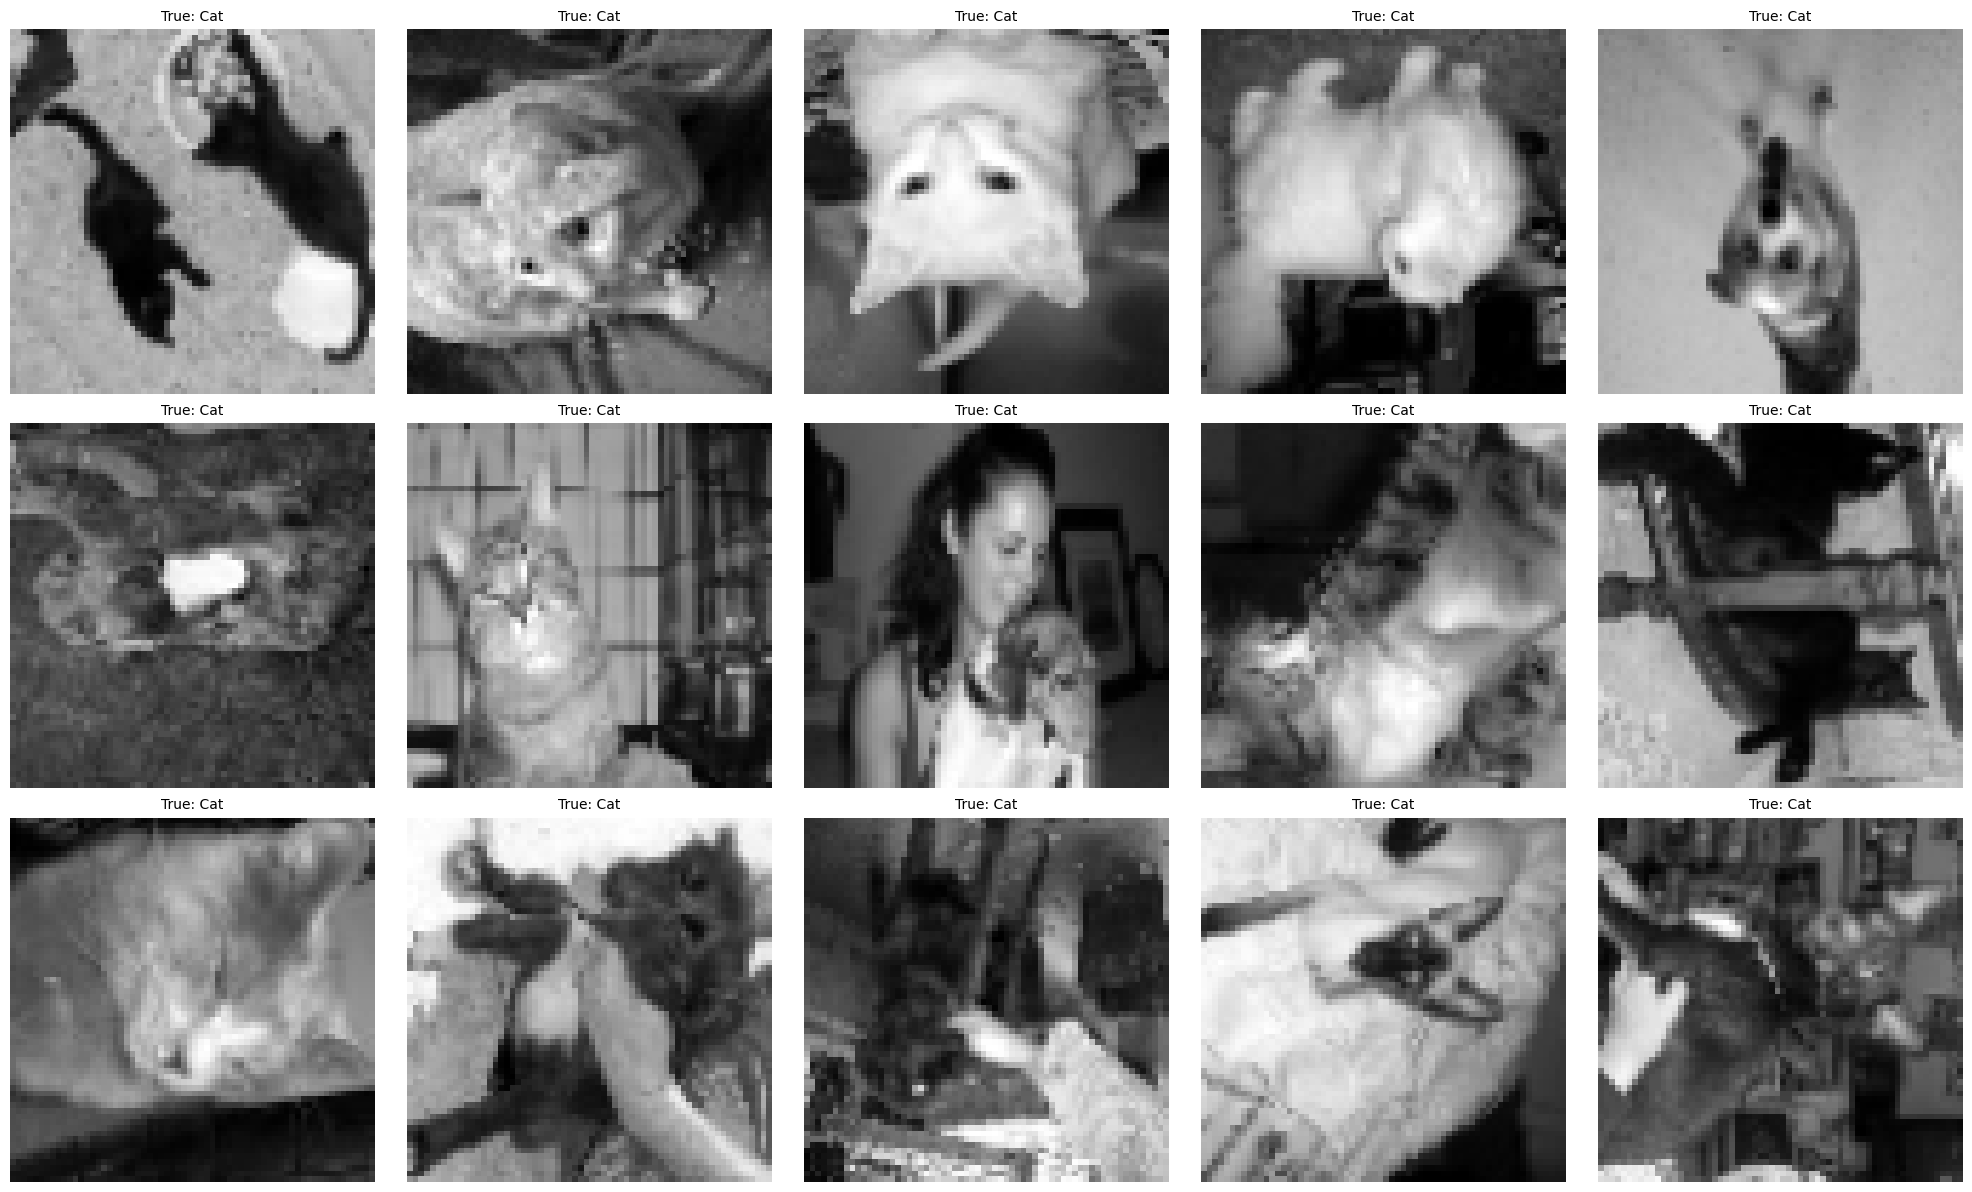

Preprocessing data...


/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [4]:
# =======================================
# 1. Load and Preprocess Data
# =======================================
X_train, y_train, X_val, y_val, X_test, y_test = load_data()
img_shape = X_train.shape[1:]

# Data Augmentation Function
def augment_image(
    image: tf.Tensor
) -> tf.Tensor:
    """
    Apply data augmentation to a single image tensor

    Parameters: 
    image : tf.Tensor
        Input image tensor  
        
    Returns:
    tf.Tensor
        Augmented image tensor
    """
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Small rotations
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random brightness / contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Small zoom (crop + resize)
    crop_scale = tf.random.uniform([], 0.9, 1.0)
    crop_size = tf.cast(crop_scale * tf.cast(tf.shape(image)[:2], tf.float32), tf.int32)
    image = tf.image.random_crop(image, size=tf.concat([crop_size, tf.shape(image)[-1:]], axis=0))
    image = tf.image.resize(image, img_shape[:2])
    
    return image

# Apply augmentation to the whole dataset
X_train_aug = []
for i in range(X_train.shape[0]):
    img = tf.convert_to_tensor(X_train[i], dtype=tf.float32)
    if len(img.shape) == 2:  # Add channel dimension if missing
        img = tf.expand_dims(img, axis=-1)
    img_aug = augment_image(img)
    X_train_aug.append(img_aug.numpy())

X_train = np.array(X_train_aug)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
plot_images(X_train, y_train, num_images=15)

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# One-hot encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

input_dim = int(X_train.shape[1])
output_dim = int(len(np.unique(y_train)))

[I 2025-11-01 21:22:30,115] A new study created in memory with name: no-name-6522fb53-5746-4944-b9dc-cf31588ea6fd


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8340 - sparse_categorical_accuracy: 0.5572 - val_loss: 2.1635 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8096 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.0201 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7255 - sparse_categorical_accuracy: 0.5577 - val_loss: 0.8683 - val_sparse_categorical_accuracy: 0.5200
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7382 - sparse_categorical_accuracy: 0.5785 - val_loss: 0.7625 - val_sparse_categorical_accuracy: 0.5500
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6938 - sparse_categorical_accuracy: 0.6134 - val_loss: 0.7625 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7117 - sparse_categorical_accuracy: 0.5701 - val_loss: 0.7743 - val_sparse_categorical_accuracy: 0.5100
Epoch 7/50
32/32

2025-11-01 21:22:35.379576: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-11-01 21:22:35,380] Trial 0 finished with value: 0.6706497073173523 and parameters: {'n_layers': 4, 'n_units_l0': 96, 'n_units_l1': 105, 'n_units_l2': 207, 'n_units_l3': 116, 'activation': 'relu', 'dropout_l0': 0.18986174112828355, 'dropout_l1': 0.16349147814529874, 'dropout_l2': 0.20896530392682772, 'dropout_l3': 0.18911335968439624, 'weight_decay': 0.0007682450292717165, 'lr': 0.0007704887907000976, 'batch_size': 32, 'step_size': 6.6390064136901366, 'gamma': 0.8476468789740392, 'stopping_patience': 11}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.8514 - sparse_categorical_accuracy: 0.5324 - val_loss: 1.1920 - val_sparse_categorical_accuracy: 0.4300
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7448 - sparse_categorical_accuracy: 0.5635 - val_loss: 1.0468 - val_sparse_categorical_accuracy: 0.4700
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7282 - sparse_categorical_accuracy: 0.5967 - val_loss: 0.9649 - val_sparse_categorical_accuracy: 0.4800
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6805 - sparse_categorical_accuracy: 0.6127 - val_loss: 0.9406 - val_sparse_categorical_accuracy: 0.4800
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.6445 - val_loss: 0.9341 - val_sparse_categorical_accuracy: 0.5100
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6152 - sparse_categorical_accuracy: 0.6656 - val_loss: 0.9347 - val_sparse_categorical_accuracy: 0.4800
Epoch 7/50

2025-11-01 21:22:41.459124: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-11-01 21:22:41,460] Trial 1 finished with value: 0.9067888259887695 and parameters: {'n_layers': 3, 'n_units_l0': 459, 'n_units_l1': 376, 'n_units_l2': 136, 'activation': 'leaky_relu', 'dropout_l0': 0.29013535615059216, 'dropout_l1': 0.3284686458020738, 'dropout_l2': 0.2768733952849326, 'weight_decay': 0.00013086455447660342, 'lr': 0.00014874955021288596, 'batch_size': 64, 'step_size': 13.321209135047305, 'gamma': 0.7600292898691086, 'stopping_patience': 10}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.4083 - sparse_categorical_accuracy: 0.4717 - val_loss: 0.9057 - val_sparse_categorical_accuracy: 0.5400
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8606 - sparse_categorical_accuracy: 0.5259 - val_loss: 0.7583 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7539 - sparse_categorical_accuracy: 0.5232 - val_loss: 0.7532 - val_sparse_categorical_accuracy: 0.5700
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7273 - sparse_categorical_accuracy: 0.5610 - val_loss: 0.7088 - val_sparse_categorical_accuracy: 0.4800
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7460 - sparse_categorical_accuracy: 0.5605 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.5600
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6787 - sparse_categorical_accuracy: 0.5958 - val_loss: 0.7184 - val_sparse_categorical_accuracy: 0.5400
Epoch 7/50
8/8 ━━━━━━━━━━━━

[I 2025-11-01 21:22:43,912] Trial 2 finished with value: 0.7077456116676331 and parameters: {'n_layers': 2, 'n_units_l0': 130, 'n_units_l1': 267, 'activation': 'tanh', 'dropout_l0': 0.3093837102044131, 'dropout_l1': 0.2472226748200209, 'weight_decay': 1.3082007092029097e-05, 'lr': 0.0023018459000023876, 'batch_size': 128, 'step_size': 18.336884314002578, 'gamma': 0.9123316042552705, 'stopping_patience': 11}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.8797 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.6809 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7859 - sparse_categorical_accuracy: 0.5128 - val_loss: 1.5736 - val_sparse_categorical_accuracy: 0.5300
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7730 - sparse_categorical_accuracy: 0.5392 - val_loss: 1.1921 - val_sparse_categorical_accuracy: 0.5200
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7087 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.0278 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7137 - sparse_categorical_accuracy: 0.5843 - val_loss: 0.9732 - val_sparse_categorical_accuracy: 0.5100
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6692 - sparse_categorical_accuracy: 0.5956 - val_loss: 0.8792 - val_sparse_categorical_accuracy: 0.4600
Epoch 7/50
16/1

2025-11-01 21:22:48.618928: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-11-01 21:22:48,620] Trial 3 finished with value: 0.8196970224380493 and parameters: {'n_layers': 4, 'n_units_l0': 104, 'n_units_l1': 281, 'n_units_l2': 83, 'n_units_l3': 69, 'activation': 'leaky_relu', 'dropout_l0': 0.19442689600109034, 'dropout_l1': 0.2378432929376593, 'dropout_l2': 0.3873005048896069, 'dropout_l3': 0.2454936679723948, 'weight_decay': 2.367770446229577e-06, 'lr': 0.001954578110839117, 'batch_size': 64, 'step_size': 17.395948594879133, 'gamma': 0.8357385433201401, 'stopping_patience': 11}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0291 - sparse_categorical_accuracy: 0.5288 - val_loss: 1.4693 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8394 - sparse_categorical_accuracy: 0.5549 - val_loss: 2.1159 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7131 - sparse_categorical_accuracy: 0.5991 - val_loss: 1.8251 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7181 - sparse_categorical_accuracy: 0.5908 - val_loss: 1.3507 - val_sparse_categorical_accuracy: 0.4800
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6619 - sparse_categorical_accuracy: 0.6472 - val_loss: 1.2141 - val_sparse_categorical_accuracy: 0.4600
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5997 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.9968 - val_sparse_categorical_accuracy: 0.4500
Epoch 7/50
16/1

[I 2025-11-01 21:22:51,297] Trial 4 finished with value: 0.9618613719940186 and parameters: {'n_layers': 2, 'n_units_l0': 113, 'n_units_l1': 460, 'activation': 'leaky_relu', 'dropout_l0': 0.22244684176320317, 'dropout_l1': 0.35793695863395253, 'weight_decay': 3.2770583794900124e-05, 'lr': 0.0026492497023718705, 'batch_size': 64, 'step_size': 13.065659627416284, 'gamma': 0.9575302907958094, 'stopping_patience': 6}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0199 - sparse_categorical_accuracy: 0.5158 - val_loss: 0.7378 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7017 - sparse_categorical_accuracy: 0.5806 - val_loss: 0.7341 - val_sparse_categorical_accuracy: 0.5300
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6494 - sparse_categorical_accuracy: 0.6324 - val_loss: 0.7542 - val_sparse_categorical_accuracy: 0.5300
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6474 - sparse_categorical_accuracy: 0.6219 - val_loss: 0.7892 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.6674 - val_loss: 0.8150 - val_sparse_categorical_accuracy: 0.4600
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5705 - sparse_categorical_accuracy: 0.7096 - val_loss: 0.8241 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/50
16/1

[I 2025-11-01 21:22:54,954] Trial 5 finished with value: 0.7249231338500977 and parameters: {'n_layers': 2, 'n_units_l0': 292, 'n_units_l1': 246, 'activation': 'tanh', 'dropout_l0': 0.27042152162388056, 'dropout_l1': 0.2054036480185787, 'weight_decay': 2.7660964321477423e-05, 'lr': 0.0004877112498560763, 'batch_size': 64, 'step_size': 8.187133577193872, 'gamma': 0.7610128143053315, 'stopping_patience': 13}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.9087 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.1474 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7199 - sparse_categorical_accuracy: 0.6218 - val_loss: 1.2072 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6655 - sparse_categorical_accuracy: 0.6535 - val_loss: 1.2080 - val_sparse_categorical_accuracy: 0.4700
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6050 - sparse_categorical_accuracy: 0.6925 - val_loss: 1.2201 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5654 - sparse_categorical_accuracy: 0.6987 - val_loss: 1.1787 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5073 - sparse_categorical_accuracy: 0.7388 - val_loss: 1.1472 - val_sparse_categorical_accuracy: 0.4200
Epoch 7/50
8/8 ━━━━━━━

[I 2025-11-01 21:23:01,376] Trial 6 finished with value: 0.9664159417152405 and parameters: {'n_layers': 3, 'n_units_l0': 428, 'n_units_l1': 111, 'n_units_l2': 198, 'activation': 'leaky_relu', 'dropout_l0': 0.14030581765260364, 'dropout_l1': 0.2486634662351189, 'dropout_l2': 0.18960227800606202, 'weight_decay': 0.0003025809022662906, 'lr': 0.00015343764741410185, 'batch_size': 128, 'step_size': 8.946846385148488, 'gamma': 0.7770406911458061, 'stopping_patience': 15}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.3445 - sparse_categorical_accuracy: 0.4766 - val_loss: 0.7103 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6834 - sparse_categorical_accuracy: 0.5983 - val_loss: 0.7261 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.6307 - val_loss: 0.7704 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.6586 - val_loss: 0.8314 - val_sparse_categorical_accuracy: 0.5300
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5923 - sparse_categorical_accuracy: 0.6717 - val_loss: 0.7744 - val_sparse_categorical_accuracy: 0.4800
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5400 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.8809 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/50
16/1

2025-11-01 21:23:04.029164: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-11-01 21:23:04,030] Trial 7 finished with value: 0.7077089548110962 and parameters: {'n_layers': 2, 'n_units_l0': 152, 'n_units_l1': 432, 'activation': 'tanh', 'dropout_l0': 0.10713679137466932, 'dropout_l1': 0.14590840514185432, 'weight_decay': 7.66947887257893e-05, 'lr': 0.000663333222523875, 'batch_size': 64, 'step_size': 7.230515117888833, 'gamma': 0.7311298856166125, 'stopping_patience': 12}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.3215 - sparse_categorical_accuracy: 0.5126 - val_loss: 1.1212 - val_sparse_categorical_accuracy: 0.5300
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8713 - sparse_categorical_accuracy: 0.5357 - val_loss: 0.7615 - val_sparse_categorical_accuracy: 0.5200
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7577 - sparse_categorical_accuracy: 0.5339 - val_loss: 0.7278 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7954 - sparse_categorical_accuracy: 0.4923 - val_loss: 0.7728 - val_sparse_categorical_accuracy: 0.5500
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6989 - sparse_categorical_accuracy: 0.5997 - val_loss: 0.7381 - val_sparse_categorical_accuracy: 0.4700
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7324 - sparse_categorical_accuracy: 0.5328 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.5800
Epoch 7/50
8/8 ━━━━━━━

[I 2025-11-01 21:23:08,678] Trial 8 finished with value: 0.7099969387054443 and parameters: {'n_layers': 3, 'n_units_l0': 299, 'n_units_l1': 360, 'n_units_l2': 213, 'activation': 'tanh', 'dropout_l0': 0.3523232649750008, 'dropout_l1': 0.20552114003039348, 'dropout_l2': 0.33165811383739413, 'weight_decay': 1.140476403710849e-06, 'lr': 0.0036049108130802934, 'batch_size': 128, 'step_size': 12.273014867064857, 'gamma': 0.7035759186318046, 'stopping_patience': 14}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9137 - sparse_categorical_accuracy: 0.4630 - val_loss: 0.9580 - val_sparse_categorical_accuracy: 0.4700
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7827 - sparse_categorical_accuracy: 0.5551 - val_loss: 0.9223 - val_sparse_categorical_accuracy: 0.4700
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6750 - sparse_categorical_accuracy: 0.6263 - val_loss: 0.9455 - val_sparse_categorical_accuracy: 0.4700
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6973 - sparse_categorical_accuracy: 0.6094 - val_loss: 0.9354 - val_sparse_categorical_accuracy: 0.4800
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6064 - sparse_categorical_accuracy: 0.6721 - val_loss: 0.9361 - val_sparse_categorical_accuracy: 0.4800
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5609 - sparse_categorical_accuracy: 0.6801 - val_loss: 0.9953 - val_sparse_categorical_accuracy: 0.4500
Epoch 7/50


[I 2025-11-01 21:23:14,676] Trial 9 finished with value: 0.8832041025161743 and parameters: {'n_layers': 3, 'n_units_l0': 332, 'n_units_l1': 384, 'n_units_l2': 225, 'activation': 'relu', 'dropout_l0': 0.2472781052531809, 'dropout_l1': 0.24018912064807932, 'dropout_l2': 0.2504318406282898, 'weight_decay': 4.559096238568111e-05, 'lr': 0.00021249886578239837, 'batch_size': 64, 'step_size': 6.043160312066917, 'gamma': 0.8277662640783728, 'stopping_patience': 9}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9574 - sparse_categorical_accuracy: 0.5184 - val_loss: 2.0785 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7041 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.0335 - val_sparse_categorical_accuracy: 0.4600
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6798 - sparse_categorical_accuracy: 0.6075 - val_loss: 1.0395 - val_sparse_categorical_accuracy: 0.5200
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6434 - sparse_categorical_accuracy: 0.6450 - val_loss: 0.9021 - val_sparse_categorical_accuracy: 0.5300
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6070 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.7876 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5993 - sparse_categorical_accuracy: 0.6922 - val_loss: 0.8520 - val_sparse_categorical_accuracy: 0.4900
Epoch 7/50
32/3

[I 2025-11-01 21:23:19,674] Trial 10 finished with value: 0.7544062733650208 and parameters: {'n_layers': 4, 'n_units_l0': 200, 'n_units_l1': 86, 'n_units_l2': 154, 'n_units_l3': 124, 'activation': 'relu', 'dropout_l0': 0.17481347451309986, 'dropout_l1': 0.10584326485187645, 'dropout_l2': 0.11290118633436923, 'dropout_l3': 0.10563079090569014, 'weight_decay': 0.0009684472707689224, 'lr': 0.0013421535321454891, 'batch_size': 32, 'step_size': 5.116004773754733, 'gamma': 0.8638788315226104, 'stopping_patience': 7}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.8514 - sparse_categorical_accuracy: 0.5095 - val_loss: 1.8355 - val_sparse_categorical_accuracy: 0.5700
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7019 - sparse_categorical_accuracy: 0.5939 - val_loss: 1.1077 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6641 - sparse_categorical_accuracy: 0.6544 - val_loss: 0.8470 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6629 - sparse_categorical_accuracy: 0.6747 - val_loss: 0.8186 - val_sparse_categorical_accuracy: 0.4700
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6569 - sparse_categorical_accuracy: 0.6473 - val_loss: 0.8286 - val_sparse_categorical_accuracy: 0.4800
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6205 - sparse_categorical_accuracy: 0.6811 - val_loss: 0.8383 - val_sparse_categorical_accuracy: 0.5300
Epoch 7/50
32/3

[I 2025-11-01 21:23:26,003] Trial 11 finished with value: 0.8578386902809143 and parameters: {'n_layers': 4, 'n_units_l0': 198, 'n_units_l1': 167, 'n_units_l2': 256, 'n_units_l3': 119, 'activation': 'relu', 'dropout_l0': 0.10073350849396893, 'dropout_l1': 0.12807573406851785, 'dropout_l2': 0.17167734020515502, 'dropout_l3': 0.217625299181826, 'weight_decay': 0.000904502354870544, 'lr': 0.0006540841483452695, 'batch_size': 32, 'step_size': 8.627203882221018, 'gamma': 0.7182889293531256, 'stopping_patience': 12}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9342 - sparse_categorical_accuracy: 0.4774 - val_loss: 0.7972 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6830 - sparse_categorical_accuracy: 0.6254 - val_loss: 0.7386 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5813 - sparse_categorical_accuracy: 0.6900 - val_loss: 0.7793 - val_sparse_categorical_accuracy: 0.4800
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5741 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.7851 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5392 - sparse_categorical_accuracy: 0.7218 - val_loss: 1.0181 - val_sparse_categorical_accuracy: 0.5300
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5668 - sparse_categorical_accuracy: 0.7315 - val_loss: 0.7721 - val_sparse_categorical_accuracy: 0.5500
Epoch 7/50
32/32

[I 2025-11-01 21:23:29,148] Trial 12 finished with value: 0.7354743480682373 and parameters: {'n_layers': 2, 'n_units_l0': 196, 'n_units_l1': 509, 'activation': 'tanh', 'dropout_l0': 0.10439637208875993, 'dropout_l1': 0.16119485588202212, 'weight_decay': 0.0001924288635972495, 'lr': 0.00035060639858777585, 'batch_size': 32, 'step_size': 10.225885669152568, 'gamma': 0.8823013358124274, 'stopping_patience': 8}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9006 - sparse_categorical_accuracy: 0.5204 - val_loss: 1.2105 - val_sparse_categorical_accuracy: 0.5800
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8255 - sparse_categorical_accuracy: 0.5267 - val_loss: 0.7946 - val_sparse_categorical_accuracy: 0.5200
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7842 - sparse_categorical_accuracy: 0.5705 - val_loss: 0.8370 - val_sparse_categorical_accuracy: 0.5200
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7434 - sparse_categorical_accuracy: 0.5687 - val_loss: 0.8053 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7048 - sparse_categorical_accuracy: 0.6129 - val_loss: 0.7545 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7019 - sparse_categorical_accuracy: 0.5973 - val_loss: 0.8134 - val_sparse_categorical_accuracy: 0.4900
Epoch 7/50
32/32

[I 2025-11-01 21:23:33,637] Trial 13 finished with value: 0.7174079418182373 and parameters: {'n_layers': 4, 'n_units_l0': 76, 'n_units_l1': 181, 'n_units_l2': 111, 'n_units_l3': 97, 'activation': 'relu', 'dropout_l0': 0.1590091983318045, 'dropout_l1': 0.15695097235516645, 'dropout_l2': 0.1831508174113465, 'dropout_l3': 0.3912319390681611, 'weight_decay': 6.242541073606954e-06, 'lr': 0.0009535373044797323, 'batch_size': 32, 'step_size': 6.757294618251035, 'gamma': 0.8058747344692031, 'stopping_patience': 13}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8429 - sparse_categorical_accuracy: 0.5113 - val_loss: 0.7497 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7264 - sparse_categorical_accuracy: 0.5486 - val_loss: 0.7786 - val_sparse_categorical_accuracy: 0.5300
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6869 - sparse_categorical_accuracy: 0.5956 - val_loss: 0.7358 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6488 - sparse_categorical_accuracy: 0.6499 - val_loss: 0.7497 - val_sparse_categorical_accuracy: 0.5600
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6180 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.7452 - val_sparse_categorical_accuracy: 0.5200
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6119 - sparse_categorical_accuracy: 0.6544 - val_loss: 0.8465 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/50
32/32

[I 2025-11-01 21:23:37,728] Trial 14 finished with value: 0.7167388200759888 and parameters: {'n_layers': 3, 'n_units_l0': 170, 'n_units_l1': 431, 'n_units_l2': 182, 'activation': 'tanh', 'dropout_l0': 0.21079260603368233, 'dropout_l1': 0.3116441821955909, 'dropout_l2': 0.11718108471232824, 'weight_decay': 9.251423361362979e-05, 'lr': 0.000325137651591223, 'batch_size': 32, 'step_size': 11.121085361307236, 'gamma': 0.9802622003278404, 'stopping_patience': 10}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.8338 - sparse_categorical_accuracy: 0.5292 - val_loss: 2.5909 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6971 - sparse_categorical_accuracy: 0.5875 - val_loss: 1.9671 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6908 - sparse_categorical_accuracy: 0.6210 - val_loss: 1.1757 - val_sparse_categorical_accuracy: 0.4700
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6471 - sparse_categorical_accuracy: 0.6058 - val_loss: 0.9890 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6372 - sparse_categorical_accuracy: 0.6560 - val_loss: 1.0554 - val_sparse_categorical_accuracy: 0.5100
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5771 - sparse_categorical_accuracy: 0.7134 - val_loss: 0.9461 - val_sparse_categorical_accuracy: 0.4800
Epoch 7/50
16/1

2025-11-01 21:23:42.696929: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-11-01 21:23:42,698] Trial 15 finished with value: 0.9249647855758667 and parameters: {'n_layers': 4, 'n_units_l0': 246, 'n_units_l1': 204, 'n_units_l2': 252, 'n_units_l3': 101, 'activation': 'relu', 'dropout_l0': 0.13618224146227875, 'dropout_l1': 0.17098842870919, 'dropout_l2': 0.32105258918094093, 'dropout_l3': 0.13884643294355342, 'weight_decay': 0.0005301786099720763, 'lr': 0.0010262847467114864, 'batch_size': 64, 'step_size': 15.42585937031608, 'gamma': 0.7340371433689029, 'stopping_patience': 12}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0484 - sparse_categorical_accuracy: 0.5504 - val_loss: 1.4070 - val_sparse_categorical_accuracy: 0.5400
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.6424 - val_loss: 1.2303 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5451 - sparse_categorical_accuracy: 0.7365 - val_loss: 1.0154 - val_sparse_categorical_accuracy: 0.4100
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5185 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.9982 - val_sparse_categorical_accuracy: 0.4900
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4329 - sparse_categorical_accuracy: 0.8061 - val_loss: 1.0619 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3798 - sparse_categorical_accuracy: 0.8353 - val_loss: 1.0631 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/50
3

[I 2025-11-01 21:23:50,206] Trial 16 finished with value: 1.0068907737731934 and parameters: {'n_layers': 2, 'n_units_l0': 376, 'n_units_l1': 323, 'activation': 'relu', 'dropout_l0': 0.13123174466183862, 'dropout_l1': 0.11221656828001009, 'weight_decay': 9.03925216779104e-05, 'lr': 0.0005823635058428608, 'batch_size': 32, 'step_size': 7.166726707516882, 'gamma': 0.793271000722668, 'stopping_patience': 15}. Best is trial 0 with value: 0.6706497073173523.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8583 - sparse_categorical_accuracy: 0.5187 - val_loss: 0.6854 - val_sparse_categorical_accuracy: 0.5800
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7635 - sparse_categorical_accuracy: 0.5442 - val_loss: 0.6974 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7663 - sparse_categorical_accuracy: 0.5291 - val_loss: 0.6886 - val_sparse_categorical_accuracy: 0.4900
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7617 - sparse_categorical_accuracy: 0.5087 - val_loss: 0.7394 - val_sparse_categorical_accuracy: 0.5600
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7128 - sparse_categorical_accuracy: 0.5769 - val_loss: 0.7404 - val_sparse_categorical_accuracy: 0.4600
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7340 - sparse_categorical_accuracy: 0.5359 - val_loss: 0.7318 - val_sparse_categorical_accuracy: 0.4900
Epoch 6: early s

[I 2025-11-01 21:23:52,887] Trial 17 finished with value: 0.6478585004806519 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 139, 'n_units_l2': 172, 'activation': 'tanh', 'dropout_l0': 0.3838119822890656, 'dropout_l1': 0.19695190938178864, 'dropout_l2': 0.21407322371102278, 'weight_decay': 0.00033240439803446326, 'lr': 0.0013598122163703491, 'batch_size': 32, 'step_size': 9.951384054920753, 'gamma': 0.9097240202177724, 'stopping_patience': 5}. Best is trial 17 with value: 0.6478585004806519.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8215 - sparse_categorical_accuracy: 0.5679 - val_loss: 1.2714 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7770 - sparse_categorical_accuracy: 0.5686 - val_loss: 1.0345 - val_sparse_categorical_accuracy: 0.5400
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7408 - sparse_categorical_accuracy: 0.5766 - val_loss: 0.8510 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6701 - sparse_categorical_accuracy: 0.6331 - val_loss: 0.7983 - val_sparse_categorical_accuracy: 0.5400
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7629 - sparse_categorical_accuracy: 0.5547 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.5300
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6929 - sparse_categorical_accuracy: 0.5785 - val_loss: 0.7586 - val_sparse_categorical_accuracy: 0.5100
Epoch 7/50
32/32

[I 2025-11-01 21:23:55,887] Trial 18 finished with value: 0.7259851098060608 and parameters: {'n_layers': 3, 'n_units_l0': 76, 'n_units_l1': 136, 'n_units_l2': 173, 'activation': 'relu', 'dropout_l0': 0.3976116674044878, 'dropout_l1': 0.19619437906772907, 'dropout_l2': 0.21673155057742402, 'weight_decay': 0.00032326823043063327, 'lr': 0.0011733182107274143, 'batch_size': 32, 'step_size': 10.148546985331665, 'gamma': 0.91007293236009, 'stopping_patience': 5}. Best is trial 17 with value: 0.6478585004806519.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9063 - sparse_categorical_accuracy: 0.4853 - val_loss: 0.7457 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7711 - sparse_categorical_accuracy: 0.5229 - val_loss: 0.7120 - val_sparse_categorical_accuracy: 0.5600
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7512 - sparse_categorical_accuracy: 0.5400 - val_loss: 0.7367 - val_sparse_categorical_accuracy: 0.5300
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7267 - sparse_categorical_accuracy: 0.5299 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.5100
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7026 - sparse_categorical_accuracy: 0.5327 - val_loss: 0.7044 - val_sparse_categorical_accuracy: 0.5300
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6810 - sparse_categorical_accuracy: 0.5815 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.5500
Epoch 7/50
32/3

[I 2025-11-01 21:24:00,332] Trial 19 finished with value: 0.6935229301452637 and parameters: {'n_layers': 4, 'n_units_l0': 244, 'n_units_l1': 72, 'n_units_l2': 144, 'n_units_l3': 111, 'activation': 'tanh', 'dropout_l0': 0.3979512404472628, 'dropout_l1': 0.28846501609469877, 'dropout_l2': 0.23386273038964173, 'dropout_l3': 0.34964311481948007, 'weight_decay': 0.00045534449582678447, 'lr': 0.003600592869752555, 'batch_size': 32, 'step_size': 14.879604128196704, 'gamma': 0.9380491593378294, 'stopping_patience': 5}. Best is trial 17 with value: 0.6478585004806519.


Best trial:
  Value: 0.6479
  Params:
    n_layers: 3
    n_units_l0: 72
    n_units_l1: 139
    n_units_l2: 172
    activation: tanh
    dropout_l0: 0.3838119822890656
    dropout_l1: 0.19695190938178864
    dropout_l2: 0.21407322371102278
    weight_decay: 0.00033240439803446326
    lr: 0.0013598122163703491
    batch_size: 32
    step_size: 9.951384054920753
    gamma: 0.9097240202177724
    stopping_patience: 5
Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8754 - sparse_categorical_accuracy: 0.5145 - val_loss: 0.7580 - val_sparse_categorical_accuracy: 0.4600
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7817 - sparse_categorical_accuracy: 0.5323 - val_loss: 0.7819 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7589 - sparse_categorical_accuracy: 0.5407 - val_loss: 0.7284 - val_sparse_categorical_accuracy: 0.5800
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7538 - sparse_categorical

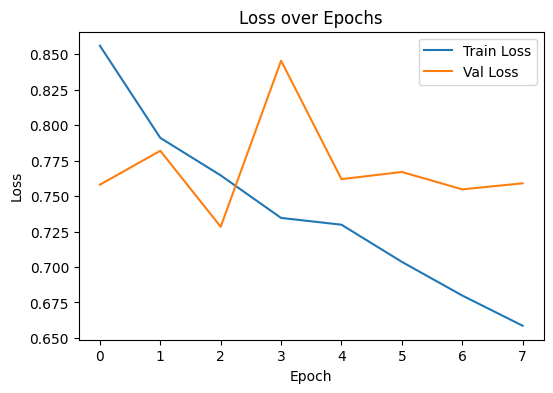

Test Accuracy: 56.00%


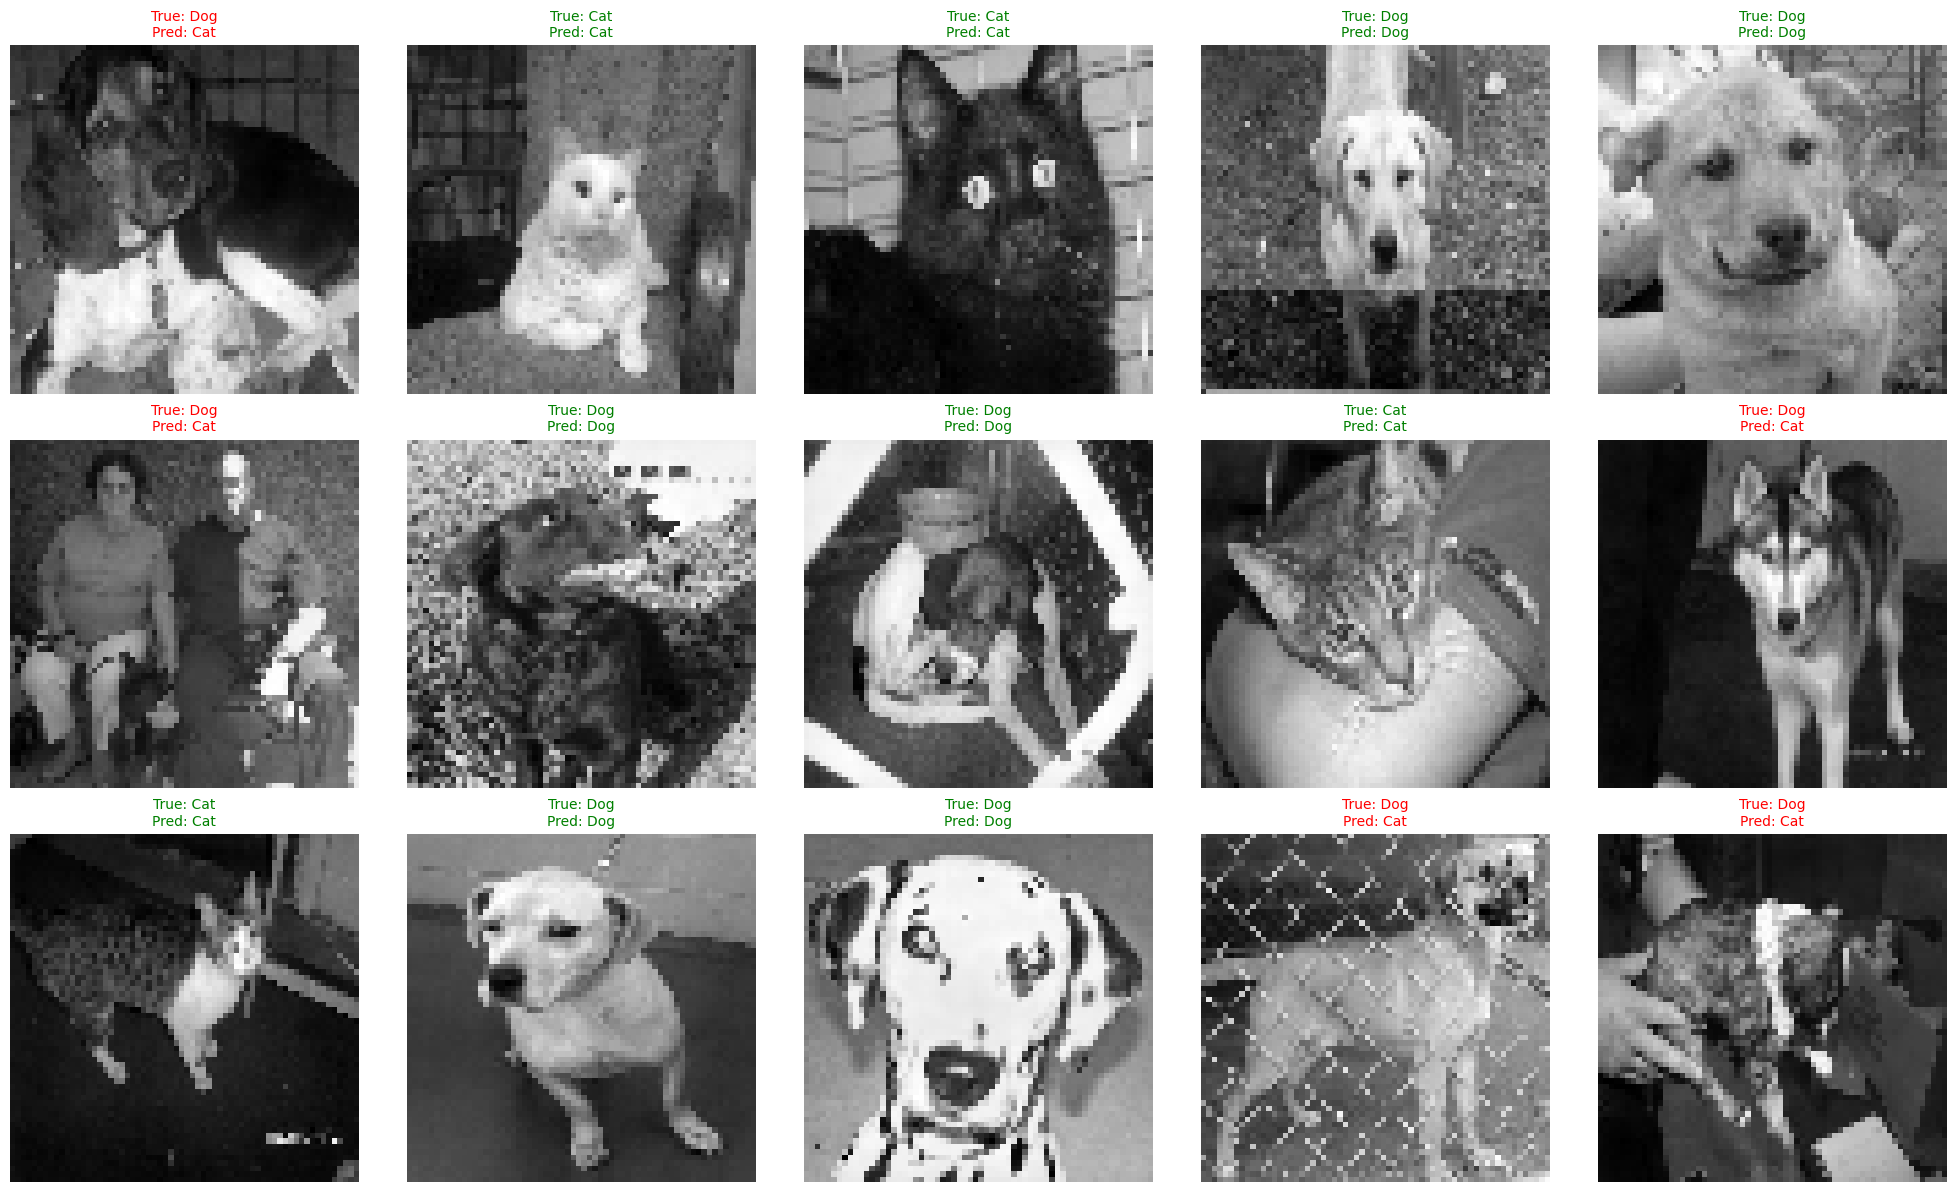

In [5]:
RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)


# =======================================
# 2. Tensor Creation
# =======================================
def df_to_tf_dataset(
    X, 
    y, 
    batch_size=64, 
    shuffle=True
) -> tf.data.Dataset:
    """
    Create a TensorFlow Dataset from features and labels

    Parameters:
    X : np.ndarray
        Feature array
    y : np.ndarray
        Label array
    batch_size : int, optional (default=64)
        Batch size for the dataset
    shuffle : bool, optional (default=True)
        Whether to shuffle the dataset

    Returns:
    tf.data.Dataset
        TensorFlow dataset object
    """
    ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.int32)))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# =======================================
# 3. Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": lambda: tf.keras.layers.ReLU(),
    "sigmoid": lambda: tf.keras.layers.Activation("sigmoid"),
    "tanh": lambda: tf.keras.layers.Activation("tanh"),
    "leaky_relu": lambda: tf.keras.layers.LeakyReLU(negative_slope=0.01),
    "gelu": lambda: tf.keras.layers.Activation(tf.nn.gelu),
    "elu": lambda: tf.keras.layers.ELU(),
    "softmax_logit": None  # handled separately for logits
}


# =======================================
# 4. Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    hidden_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    step_size: int = 20
    gamma: float = 0.5
    early_stopping: bool = True
    patience: int = 10
    clip_grad_norm: Optional[float] = 1.0
    use_amp: bool = True  # automatic mixed precision


# =======================================
# 5. Model Definition
# =======================================
class DeepNN(tf.keras.Model):
    def __init__(
        self,
        input_dim: int,
        hidden_layers: List[int],
        output_dim: int,
        activations: Optional[List[str]] = None,
        dropout_rates: Optional[List[float]] = None,
        use_batchnorm: bool = True
    ):
        """
        Deep Neural Network with configurable architecture

        Parameters:
        input_dim : int
            Dimension of input features
        hidden_layers : List[int]
            List containing the number of units in each hidden layer
        output_dim : int
            Number of output classes
        activations : List[str], optional
            List of activation function names for each hidden layer
        dropout_rates : List[float], optional
            List of dropout rates for each hidden layer
        use_batchnorm : bool, optional
            Whether to use batch normalization after each hidden layer

        Returns:
        """
        super().__init__()
        self.layers_list = []
        n_hidden = len(hidden_layers)

        if activations is None:
            activations = ["relu"] * len(hidden_layers)
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_layers)
        assert len(activations) == n_hidden
        assert len(dropout_rates) == n_hidden

        for idx, h in enumerate(hidden_layers):
            act_name = activations[idx]
            act_ctor = _ACTIVATION_MAP.get(act_name)
            # Choose weight initializer based on activation
            if act_name in ("relu", "leaky_relu"):
                kernel_init = tf.keras.initializers.HeNormal()
            else:
                kernel_init = tf.keras.initializers.GlorotNormal()  # Xavier
            # Dense layer
            self.layers_list.append(tf.keras.layers.Dense(h, kernel_initializer=kernel_init, bias_initializer="zeros"))
            # Optional batch normalization
            if use_batchnorm:
                self.layers_list.append(tf.keras.layers.BatchNormalization())
            # Activation
            if act_ctor is not None:
                self.layers_list.append(act_ctor() if callable(act_ctor) else act_ctor)
            # Dropout
            if dropout_rates[idx] and dropout_rates[idx] > 0:
                self.layers_list.append(tf.keras.layers.Dropout(dropout_rates[idx]))

        # Final linear layer → logits (no activation)
        self.layers_list.append(
            tf.keras.layers.Dense(output_dim, kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer="zeros")
        )

    def call(
        self: tf.keras.Model,
        inputs: tf.Tensor,
        training: bool = False
    ) -> tf.Tensor:
        """
        Forward pass through the network

        Parameters:
        inputs : tf.Tensor
            Input tensor
        training : bool, optional
            Whether in training mode (for dropout, batchnorm)

        Returns:
        tf.Tensor
            Output logits tensor
        """
        x = inputs
        for layer in self.layers_list:
            if isinstance(layer, tf.keras.layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x


# =======================================
# 6. Training Function
# =======================================
def train_model(
    X_train: np.ndarray,
    y_train: np.ndarray, 
    X_val: np.ndarray,
    y_val: np.ndarray,
    input_dim: int,
    output_dim: int,
    config: TrainConfig,
    plot_loss: bool = False
) -> Tuple[tf.keras.Model, tf.keras.callbacks.History]:
    """
    Train the Deep Neural Network model

    Parameters:
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    input_dim : int
        Dimension of input features
    output_dim : int
        Number of output classes
    config : TrainConfig
        Training configuration parameters
    plot_loss : bool, optional
        Whether to plot training and validation loss curves

    Returns:
    model : tf.keras.Model
        Trained model
    history : tf.keras.callbacks.History
        Training history object
    """
    # Dataloaders
    train_dataset = df_to_tf_dataset(X_train, y_train, batch_size=config.batch_size)
    val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=config.batch_size, shuffle=False)

    # AMP policy
    if config.use_amp:
        tf.keras.mixed_precision.set_global_policy("mixed_float16")

    # Model creation
    model = DeepNN(input_dim, config.hidden_layers, output_dim, config.activations, config.dropout_rates)

    # Learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=config.lr,
        decay_steps=config.step_size * len(train_dataset),
        decay_rate=config.gamma,
        staircase=True,
    )

    # Optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=config.weight_decay)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Callbacks (Early stopping + checkpoint)
    callbacks = []
    if config.early_stopping:
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=config.patience,
                restore_best_weights=True, verbose=1,
            )
        )

    callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
            filepath="best_model.weights.h5",
            monitor="val_loss",
            save_best_only=True, save_weights_only=True,
        )
    )

    # Train the model
    history = model.fit(
        train_dataset, validation_data=val_dataset,
        epochs=config.epochs,
        verbose=1,callbacks=callbacks,
    )

    # Plot losses
    if plot_loss:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history["loss"], label="Train Loss")
        plt.plot(history.history["val_loss"], label="Val Loss")
        plt.legend()
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    return model, history


# =======================================
# 7. Prediction & Evaluation
# =======================================
def predict_tf(
    model: tf.keras.Model,
    X: np.ndarray,
    y: np.ndarray, 
    batch_size: int = 64
) -> Tuple[np.ndarray, np.ndarray]: 
    """
    Predict classes and probabilities using the trained model

    Parameters:
    model : tf.keras.Model
        Trained model
    X : np.ndarray
        Input features
    y : np.ndarray
        True labels
    batch_size : int, optional
        Batch size for prediction  

    Returns:
    np.ndarray
        Predicted class labels
    np.ndarray
        Predicted class probabilities
    """
    ds = df_to_tf_dataset(X, y, batch_size=batch_size, shuffle=False) 
    probs_list = [] 
    for X_batch, _ in ds:
        logits = model(X_batch, training=False) 
        probs = tf.nn.softmax(logits) 
        probs_list.append(probs) 
    probs = tf.concat(probs_list, axis=0) 
    preds = tf.argmax(probs, axis=1).numpy()
    return preds, probs.numpy()

def accuracy_score(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> float:
    """
    Compute accuracy score between true and predicted labels

    Parameters:
    y_true : np.ndarray
        True labels
    y_pred : np.ndarray
        Predicted labels

    Returns:
    float
        Accuracy percentage
    """
    return np.mean(y_true == y_pred) * 100


# =======================================
# 8. Hyperparameter Optimization with Optuna
# =======================================
def objective(
    trial: optuna.trial.Trial,
    loss_function: str = "cross_entropy",
    epochs: int = 40
) -> float:
    """
    Objective function for Optuna hyperparameter optimization

    Parameters:
    trial : optuna.trial.Trial
        Optuna trial object
    loss_function : str, optional
        Loss function to use
    epochs : int, optional
        Number of training epochs
    Returns:
    float
        Validation loss to minimize
    """
    # Number of hidden layers (shallower works better on raw pixels)
    n_layers = trial.suggest_int("n_layers", 2, 4) 

    # Decreasing width pattern (funnel architecture)
    hidden_layers = []
    for i in range(n_layers):
        max_units = max(64, input_dim // (2 ** (i + 2)))
        hidden_layers.append(trial.suggest_int(f"n_units_l{i}", 64, min(max_units, 512)))
        
    # Common activation (keeps optimization stable)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "tanh"])
    activations = [activation] * n_layers
    # possible_activations = ["relu", "tanh", "leaky_relu"]
    # activations = [trial.suggest_categorical(f"activation_l{i}", possible_activations) for i in range(n_layers)]

    # Regularization
    dropout_rates = [trial.suggest_float(f"dropout_l{i}", 0.1, 0.4) for i in range(n_layers)]
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Optimizer params
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    step_size = trial.suggest_float("step_size", 5, 20)
    gamma = trial.suggest_float("gamma", 0.7, 0.99, log=True)

    # Early stopping
    stopping_patience = trial.suggest_int("stopping_patience", 5, 15)

    config = TrainConfig(
        hidden_layers=hidden_layers, 
        activations=activations, 
        dropout_rates=dropout_rates, 
        loss_function=loss_function, 
        lr=lr, 
        batch_size=batch_size, 
        epochs=epochs, 
        weight_decay=weight_decay, 
        step_size=step_size, 
        gamma=gamma,
        early_stopping=True, 
        patience=stopping_patience, 
        use_amp=True
    )

    model, _ = train_model(
        X_train, y_train, 
        X_val, y_val,
        input_dim, output_dim,
        config,
        plot_loss=False
    )

    # Validation loss
    val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=config.batch_size)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    val_loss_metric = tf.keras.metrics.Mean()
    for X_batch, y_batch in val_dataset:
        logits = model(X_batch, training=False)
        val_loss_metric.update_state(loss_fn(y_batch, logits))

    return val_loss_metric.result().numpy()


# Run Optuna study
loss_function = "cross_entropy"
epochs = 50
obj = partial(objective, loss_function=loss_function, epochs=epochs)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(obj, n_trials=20)

# Best result summary
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


# =======================================
# 9. Retrain Best Model on Train + Val and Evaluate on Test
# =======================================
best_params = trial.params
n_layers = best_params["n_layers"]
hidden_layers = [best_params[f"n_units_l{i}"] for i in range(n_layers)]
lr = best_params["lr"]
batch_size = best_params["batch_size"]
dropout_rates = [best_params[f"dropout_l{i}"] for i in range(n_layers)]
weight_decay = best_params["weight_decay"]
stopping_patience = best_params["stopping_patience"]
# activations = [best_params[f"activation_l{i}"] for i in range(n_layers)]
activations = [best_params["activation"]] * n_layers
step_size = best_params["step_size"]
gamma = best_params["gamma"]

config = TrainConfig(
    hidden_layers=hidden_layers, 
    activations=activations, 
    dropout_rates=dropout_rates, 
    loss_function=loss_function, 
    lr=lr, 
    batch_size=batch_size, 
    epochs=epochs*3, 
    weight_decay=weight_decay, 
    step_size=step_size, 
    gamma=gamma,
    early_stopping=True, 
    patience=stopping_patience, 
    use_amp=True
    )

# Retrain final model
best_model, history = train_model(
    X_train, y_train,
    X_val, y_val,
    input_dim, output_dim,
    config,
    plot_loss=True
)

# Evaluate on test set
y_pred_test, _ = predict_tf(best_model, X_test, y_test, batch_size=batch_size)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_images(X_test, y_test, y_pred_test, num_images=15)